In [3]:
medpiapipe_landmarks_csv = 'mp_img_landmarks.csv'
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

In [4]:
# Mapping of regions to their general areas
region_to_area = {
    "Cheek": [
        "risorius",
        "buccinator",
        "zygomaticus_minor",
        "zygomaticus_major"
    ],
    "Jaw": [
        "depressor_anguli_oris",
        "masseter"
    ],
    "Masseter": [
        "masseter"
    ],
    "Nose": [
        "depressor_septi_nasi",
        "nasalis_transverse",
        "compressor_narium_minor",
        "nasalis_alar",
        "dilator_naris_anterior",
        "procerus",
        "radix",
        "nose_tip",
        "columella"
    ],
    "Eye": [
        "orbital_oculi",
        "orbiculi_pelperbal",
        "lateral_palpebral_ligament",
        "medial_palpebral_ligament"
    ],
    "Forehead": [
        "corrugator_supercilii",
        "frontalis"
    ],
    "Temples": [
        "temporalis"
    ],
    "Lips": [
        "obicularis_oris",
        "philtral_columns",
        "tubercles_upper",
        "tubercles_lower",
        "oral_commissure",
        "vermillion_upper",
        "cupids_bow",
        "vermillion_lower"
    ],
    "Chin": [
        "mentalis",
        "depressor_anguli_oris",
        "depressor_labii_inferioris"
    ],
    "Upper lip": [
        "levator_labii_superioris_alaque_nasi",
        "levator_labii_superioris"
    ],
    "Lower lip": [
        "depressor_labii_inferioris",
        "tubercles_lower"
    ]
}

# Example for accessing
# region_to_area["Cheek"] will give the list of muscles in the "Cheek" region


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def normalize_coordinates(df, x='x', y='y', z='z', output_range=(0, 1)):
    min_vals = df[['x', 'y', 'z']].min()
    max_vals = df[['x', 'y', 'z']].max()
    scaled_df = df.copy()
    for col in ['x', 'y', 'z']:
        scaled_df[col] = ( (df[col] - min_vals[col]) / (max_vals[col] - min_vals[col]) ) * (output_range[1] - output_range[0]) + output_range[0]
    return scaled_df

def merge_dataframes(df1, df2, key, dtype="str", suffix_df1="_df1", suffix_df2="_df2"):
    # Ensure the key column has the correct data type in both DataFrames
    if dtype == "str":
        df1[key] = df1[key].astype(str)
        df2[key] = df2[key].astype(str)
    elif dtype == "int":
        df1[key] = pd.to_numeric(df1[key], errors='coerce').astype('Int64')
        df2[key] = pd.to_numeric(df2[key], errors='coerce').astype('Int64')

    merged_df = pd.merge(df1, df2, on=key, how='inner', suffixes=(suffix_df1, suffix_df2))
    return merged_df

import pandas as pd

def normalize_coordinates(df, x='x', y='y', z='z', output_range=(0, 1)):
    min_vals = df[['x', 'y', 'z']].min()
    max_vals = df[['x', 'y', 'z']].max()
    scaled_df = df.copy()
    for col in ['x', 'y', 'z']:
        scaled_df[col] = ( (df[col] - min_vals[col]) / (max_vals[col] - min_vals[col]) ) * (output_range[1] - output_range[0]) + output_range[0]
    return scaled_df

def merge_dataframes(df1, df2, key, dtype="str", suffix_df1="_df1", suffix_df2="_df2"):
    # Ensure the key column has the correct data type in both DataFrames
    if dtype == "str":
        df1[key] = df1[key].astype(str)
        df2[key] = df2[key].astype(str)
    elif dtype == "int":
        df1[key] = pd.to_numeric(df1[key], errors='coerce').astype('Int64')
        df2[key] = pd.to_numeric(df2[key], errors='coerce').astype('Int64')

    merged_df = pd.merge(df1, df2, on=key, how='inner', suffixes=(suffix_df1, suffix_df2))
    return merged_df

def calculate_merged_means(merged_df, df1_cols, df2_cols):
    """
    Merges two DataFrames and calculates mean values for x, y, and z columns.
    Drops the original columns used for calculations from the resulting DataFrame.

    Args:
        df1 (pd.DataFrame): First DataFrame.
        df2 (pd.DataFrame): Second DataFrame.
        key (str): Column name used to merge the two DataFrames.
        df1_cols (list): List of column names for x, y, z in the first DataFrame.
        df2_cols (list): List of column names for x, y, z in the second DataFrame.

    Returns:
        pd.DataFrame: Merged DataFrame with mean columns and original columns dropped.
    """
    x1_col = df1_cols[0]
    y1_col = df1_cols[1]
    z1_col = df1_cols[2]
    x2_col = df2_cols[0]
    y2_col = df2_cols[1]
    z2_col = df2_cols[2]
    
    # Calculate means for x, y, and z
    merged_df['x_mean'] = (merged_df[f'{x1_col}'] + merged_df[f'{x2_col}']) / 2
    merged_df['y_mean'] = (merged_df[f'{y1_col}'] + merged_df[f'{y2_col}']) / 2

    if f'{z1_col}' in merged_df.columns and f'{z2_col}' in merged_df.columns:
        merged_df['z_mean'] = (merged_df[f'{z1_col}'] + merged_df[f'{z2_col}']) / 2
    elif f'{z1_col}' in merged_df.columns:
        merged_df['z_mean'] = merged_df[f'{z1_col}']
    elif f'{z2_col}' in merged_df.columns:
        merged_df['z_mean'] = merged_df[f'{z2_col}']
    else:
        merged_df['z_mean'] = None

    # Drop the original columns used for calculations
    columns_to_drop = [x1_col, y1_col, z1_col, x2_col, y2_col, z2_col]
    columns_to_drop = [col for col in columns_to_drop if col in merged_df.columns]  # Handle missing columns
    merged_df = merged_df.drop(columns=columns_to_drop)

    return merged_df


In [6]:
import pandas as pd


medpiapipe_landmarks_csv = 'mp_img_landmarks.csv'
keypoints_df = pd.read_csv('keypoints')
segments_df = pd.read_csv('segments')
landmarks_df = pd.read_csv(medpiapipe_landmarks_csv)

#landmarks_df = normalize_coordinates(landmarks_df)
keypoints_df.rename(columns={'point':'landmark'}, inplace=True)
landmarks_df.rename(columns={'point':'landmark'}, inplace=True)

In [7]:
keypoints_df.drop(columns=['Unnamed: 0'], inplace=True)


# Keypoint Analysis

In [8]:
keypoints_df['z'] = landmarks_df['z']
keypoints_df # Dataframe from the annotation

,id,image_id,category_id,num_keypoints,bbox,area,iscrowd,name,region,side,landmark,z,injection_name,injection_point,area.1,x,y,visibility,id_image,file_name
0,1,1,1,1,"[0.492109375, 0.716357421875, 0.0, 0.0]",1,0,landmark,cupids_bow,center,0,-0.062283,NaN,False,eye,0.492109,0.716357,2.0,1,NaN
1,2,1,1,1,"[0.340966796875, 0.405107421875, 0.0, 0.0]",1,0,landmark,orbiculi_pelperbal,left,27,-0.130272,NaN,False,eye,0.340967,0.405107,2.0,1,NaN
2,3,1,1,1,"[0.375537109375, 0.408037109375, 0.0, 0.0]",1,0,landmark,orbiculi_pelperbal,left,28,-0.063943,NaN,False,eye,0.375537,0.408037,2.0,1,NaN
3,4,1,1,1,"[0.303828125, 0.44912109375, 0.0, 0.0]",1,0,landmark,lateral_palpebral_ligament,left,33,-0.103352,NaN,False,eye,0.303828,0.449121,2.0,1,NaN
4,5,1,1,1,"[0.2844921875, 0.48525390625, 0.0, 0.0]",1,0,landmark,orbital_oculi,left,31,-0.141000,NaN,False,eye,0.284492,0.485254,2.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,74,1,1,1,"[0.331640625, 0.442646484375, 0.0, 0.0]",1,0,landmark,pupil,right,471,0.004868,NaN,False,eye,0.331641,0.442646,2.0,1,NaN
474,75,1,1,1,"[0.3596484375, 0.442646484375, 0.0, 0.0]",1,0,landmark,pupil,right,468,0.004580,NaN,False,eye,0.359648,0.442646,2.0,1,NaN
475,76,1,1,1,"[0.388134765625, 0.442880859375, 0.0, 0.0]",1,0,landmark,pupil,right,469,0.004589,NaN,False,eye,0.388135,0.442881,2.0,1,NaN
476,77,1,1,1,"[0.779267578125, 0.5223046875, 0.0, 0.0]",1,0,landmark,zygomaticus_major,right,447,0.004555,NaN,False,masseter,0.779268,0.522305,2.0,1,NaN


# Mapping Landmark and Segmentation Data
Use KDTree to map landmarks to segmentation annotation data

In [9]:
import pandas as pd

def group_and_collapse(df, group_columns):
    """
    Groups the DataFrame by specified columns and collapses all other columns into lists of unique values.

    Args:
        df (pd.DataFrame): The DataFrame to process.
        group_columns (list): The columns to group by.

    Returns:
        pd.DataFrame: A grouped DataFrame with other columns collapsed into lists of unique values.
    """
    def unique_hashable(values):
        """
        Helper function to ensure unique values for hashable elements,
        converting unhashable types (e.g., lists) into tuples.
        """
        # Convert each element to a tuple if it's a list, else keep as-is
        processed_values = [tuple(v) if isinstance(v, list) else v for v in values]
        unique_values = list(set(processed_values))  # Ensure uniqueness
        
        # Convert tuples back to lists for polygon format
        return [list(v) if isinstance(v, tuple) else v for v in unique_values]

    # Group by the specified columns and aggregate other columns into unique lists
    grouped_df = df.groupby(group_columns).agg(
        {col: lambda x: unique_hashable(x) for col in df.columns if col not in group_columns}
    ).reset_index()

    return grouped_df


In [10]:
def unravel_list_from_column(df, column):
    df[column] = df[column].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
    return df

In [11]:
import ast
"""
Utility Function to parse the segmentation polygon coordinates since they are initially stored as a string.
"""
def safe_parse(row):
    try:
        return ast.literal_eval(row)
    except (ValueError, SyntaxError):
        return None  # Return None for malformed rows

segments_poly = pd.DataFrame(segments_df[["category_id","name","segmentation"]])
segments_poly["segmentation"] = segments_df["segmentation"].apply(safe_parse)
segments_poly

,category_id,name,segmentation
0,8,depressor_septi_nasi,"[[0.47984375, 0.638046875, 0.476328125, 0.6440..."
1,8,depressor_septi_nasi,"[[0.38255859375, 0.307939453125, 0.39244140625..."
2,5,corrugator_supercilii,"[[0.317548828125, 0.33736328125, 0.32388671875..."
3,21,nasalis_transverse,"[[0.497548828125, 0.457421875, 0.48849609375, ..."
4,4,compressor_narium_minor,"[[0.44349609375, 0.581826171875, 0.44014648437..."
...,...,...,...
71,37,cupids_bow,"[[0.5344140625, 0.70025390625, 0.53802734375, ..."
72,43,lateral_palpebral_ligament,"[[0.71166015625, 0.4341796875, 0.70716796875, ..."
73,18,medial_palpebral_ligament,"[[0.586884765625, 0.44544921875, 0.58249023437..."
74,27,platysma,"[[0.71828125, 0.795224609375, 0.71119140625, 0..."


In [12]:
segments_poly = unravel_list_from_column(segments_poly,'segmentation')
segments_poly = group_and_collapse(segments_poly,'name')
segments_poly = unravel_list_from_column(segments_poly,'category_id')
segments_poly

,name,category_id,segmentation
0,buccinator,3,"[[0.71576171875, 0.64619140625, 0.7051171875, ..."
1,columella,45,"[[0.4982421875, 0.61640625, 0.489833984375, 0...."
2,compressor_narium_minor,4,"[[0.44349609375, 0.581826171875, 0.44014648437..."
3,corrugator_supercilii,5,"[[0.317548828125, 0.33736328125, 0.32388671875..."
4,cupids_bow,37,"[[0.5344140625, 0.70025390625, 0.53802734375, ..."
5,depressor_anguli_oris,6,"[[0.357080078125, 0.74513671875, 0.34186523437..."
6,depressor_labii_inferioris,7,"[[0.59154296875, 0.778515625, 0.60462890625, 0..."
7,depressor_septi_nasi,8,"[[0.47984375, 0.638046875, 0.476328125, 0.6440..."
8,dilator_naris_anterior,10,"[[0.53046875, 0.571435546875, 0.531279296875, ..."
9,frontalis,11,"[[0.498603515625, 0.00078125, 0.49619140625, 0..."


# Regions and Areas and Names

In [13]:

def get_unique_values(df, column_name):
    # Check if the column exists in the DataFrame
    if column_name in df.columns:
        # Return the unique values in the specified column
        return df[column_name].unique().tolist()
    else:
        # If the column doesn't exist, raise an error
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")
    
segments_list = get_unique_values(segments_poly, 'name')


In [14]:
def assign_area(df):
    muscle_to_area = {muscle: region for region, muscles in region_to_area.items() for muscle in muscles}
    df['area'] = df['name'].map(lambda muscle: muscle_to_area.get(muscle, 'Unknown'))
    return df
def prettify_region_names(df):
    df['region_name'] = df['name'].str.replace('_', ' ').str.title()
    return df

In [15]:
segments_poly = assign_area(segments_poly)
segments_poly = prettify_region_names(segments_poly)
segments_poly

,name,category_id,segmentation,area,region_name
0,buccinator,3,"[[0.71576171875, 0.64619140625, 0.7051171875, ...",Cheek,Buccinator
1,columella,45,"[[0.4982421875, 0.61640625, 0.489833984375, 0....",Nose,Columella
2,compressor_narium_minor,4,"[[0.44349609375, 0.581826171875, 0.44014648437...",Nose,Compressor Narium Minor
3,corrugator_supercilii,5,"[[0.317548828125, 0.33736328125, 0.32388671875...",Forehead,Corrugator Supercilii
4,cupids_bow,37,"[[0.5344140625, 0.70025390625, 0.53802734375, ...",Lips,Cupids Bow
5,depressor_anguli_oris,6,"[[0.357080078125, 0.74513671875, 0.34186523437...",Chin,Depressor Anguli Oris
6,depressor_labii_inferioris,7,"[[0.59154296875, 0.778515625, 0.60462890625, 0...",Lower lip,Depressor Labii Inferioris
7,depressor_septi_nasi,8,"[[0.47984375, 0.638046875, 0.476328125, 0.6440...",Nose,Depressor Septi Nasi
8,dilator_naris_anterior,10,"[[0.53046875, 0.571435546875, 0.531279296875, ...",Nose,Dilator Naris Anterior
9,frontalis,11,"[[0.498603515625, 0.00078125, 0.49619140625, 0...",Forehead,Frontalis


In [16]:
from scipy.spatial import KDTree
import pandas as pd
import numpy as np


In [17]:
def map_landmarks_to_regions(
    segmentation_df, landmarks_df, segmentation_column='segmentation', region_column='name'
):
    """
    Maps landmarks to their nearest segmentation region using KDTree.

    Args:
        segmentation_df (pd.DataFrame): DataFrame with segmentation polygons and region names.
                                        Must have a column with polygon coordinates.
        landmarks_df (pd.DataFrame): DataFrame with landmark x, y, z coordinates and labels.
        segmentation_column (str): Column in `segmentation_df` containing segmentation polygons.
        region_column (str): Column in `segmentation_df` containing region names.

    Returns:
        pd.DataFrame: A copy of the landmarks DataFrame with added columns `mapped_region` and `segmentation_polygon`.
    """
    # Flatten segmentation polygons into points and map to region
    flattened_points = []
    point_to_region = []
    point_to_polygon = []

    for _, row in segmentation_df.iterrows():
        for polygon in row[segmentation_column]:
            # Reshape polygon coordinates into (x, y) pairs
            points = np.array(polygon).reshape(-1, 2)
            flattened_points.extend(points)
            point_to_region.extend([row[region_column]] * len(points))
            point_to_polygon.extend([polygon] * len(points))  # Map points to their original polygon

    # Convert flattened points to a numpy array
    flattened_points = np.array(flattened_points)

    # Build KDTree for the flattened segmentation points
    kdtree = KDTree(flattened_points)

    # Map each landmark to the nearest region
    mapped_regions = []
    segmentation_polygons = []
    for _, landmark in landmarks_df.iterrows():
        distance, idx = kdtree.query([landmark['x'], landmark['y']])
        mapped_regions.append(point_to_region[idx])
        segmentation_polygons.append(point_to_polygon[idx])

    # Add the mapped regions and segmentation polygons to the landmarks DataFrame
    result_df = landmarks_df.copy()
    result_df['name'] = mapped_regions
   # result_df['segmentation_polygon'] = segmentation_polygons

    return result_df


In [18]:
mapped_landmarks_df = map_landmarks_to_regions(segments_poly, keypoints_df)
mapped_landmarks_df

,id,image_id,category_id,num_keypoints,bbox,area,iscrowd,name,region,side,landmark,z,injection_name,injection_point,area.1,x,y,visibility,id_image,file_name
0,1,1,1,1,"[0.492109375, 0.716357421875, 0.0, 0.0]",1,0,cupids_bow,cupids_bow,center,0,-0.062283,NaN,False,eye,0.492109,0.716357,2.0,1,NaN
1,2,1,1,1,"[0.340966796875, 0.405107421875, 0.0, 0.0]",1,0,orbital_oculi,orbiculi_pelperbal,left,27,-0.130272,NaN,False,eye,0.340967,0.405107,2.0,1,NaN
2,3,1,1,1,"[0.375537109375, 0.408037109375, 0.0, 0.0]",1,0,orbiculi_pelperbal,orbiculi_pelperbal,left,28,-0.063943,NaN,False,eye,0.375537,0.408037,2.0,1,NaN
3,4,1,1,1,"[0.303828125, 0.44912109375, 0.0, 0.0]",1,0,orbiculi_pelperbal,lateral_palpebral_ligament,left,33,-0.103352,NaN,False,eye,0.303828,0.449121,2.0,1,NaN
4,5,1,1,1,"[0.2844921875, 0.48525390625, 0.0, 0.0]",1,0,orbiculi_pelperbal,orbital_oculi,left,31,-0.141000,NaN,False,eye,0.284492,0.485254,2.0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,74,1,1,1,"[0.331640625, 0.442646484375, 0.0, 0.0]",1,0,orbiculi_pelperbal,pupil,right,471,0.004868,NaN,False,eye,0.331641,0.442646,2.0,1,NaN
474,75,1,1,1,"[0.3596484375, 0.442646484375, 0.0, 0.0]",1,0,orbiculi_pelperbal,pupil,right,468,0.004580,NaN,False,eye,0.359648,0.442646,2.0,1,NaN
475,76,1,1,1,"[0.388134765625, 0.442880859375, 0.0, 0.0]",1,0,orbiculi_pelperbal,pupil,right,469,0.004589,NaN,False,eye,0.388135,0.442881,2.0,1,NaN
476,77,1,1,1,"[0.779267578125, 0.5223046875, 0.0, 0.0]",1,0,zygomaticus_major,zygomaticus_major,right,447,0.004555,NaN,False,masseter,0.779268,0.522305,2.0,1,NaN


In [19]:
landmarks_side = mapped_landmarks_df[['landmark','side','name']].copy()
landmarks_side.to_csv("landmarks_sides.csv", index=False)
landmarks_side

,landmark,side,name
0,0,center,cupids_bow
1,27,left,orbital_oculi
2,28,left,orbiculi_pelperbal
3,33,left,orbiculi_pelperbal
4,31,left,orbiculi_pelperbal
...,...,...,...
473,471,right,orbiculi_pelperbal
474,468,right,orbiculi_pelperbal
475,469,right,orbiculi_pelperbal
476,447,right,zygomaticus_major


In [20]:
mapped_landmarks_df = mapped_landmarks_df[['landmark','name','x','y','z']].copy()
mapped_landmarks_df.loc[:, 'landmark_coords'] = mapped_landmarks_df.apply(lambda row: [row['x'], row['y']], axis=1)
mapped_landmarks_df = mapped_landmarks_df.drop(['x', 'y','z'], axis=1)
mapped_landmarks_df

,landmark,name,landmark_coords
0,0,cupids_bow,"[0.492109375, 0.716357421875]"
1,27,orbital_oculi,"[0.340966796875, 0.405107421875]"
2,28,orbiculi_pelperbal,"[0.375537109375, 0.408037109375]"
3,33,orbiculi_pelperbal,"[0.303828125, 0.44912109375]"
4,31,orbiculi_pelperbal,"[0.2844921875, 0.48525390625]"
...,...,...,...
473,471,orbiculi_pelperbal,"[0.331640625, 0.442646484375]"
474,468,orbiculi_pelperbal,"[0.3596484375, 0.442646484375]"
475,469,orbiculi_pelperbal,"[0.388134765625, 0.442880859375]"
476,447,zygomaticus_major,"[0.779267578125, 0.5223046875]"


In [21]:
mapped_landmarks_df = group_and_collapse(mapped_landmarks_df, 'name')
mapped_landmarks_df

,name,landmark,landmark_coords
0,buccinator,"[147, 435, 213, 214, 376, 187]","[[0.3052323232323232, 0.7442626262626263], [0...."
1,columella,"[1, 354, 141, 461, 462, 125, 94]","[[0.5067272727272727, 0.6339191919191919], [0...."
2,compressor_narium_minor,"[289, 3, 440, 360, 392, 456, 237, 239, 79, 51,...","[[0.5558249158249158, 0.591016835016835], [0.4..."
3,corrugator_supercilii,"[297, 67, 285]","[[0.5536835016835017, 0.4083030303030303], [0...."
4,cupids_bow,"[0, 267, 302]","[[0.5244781144781145, 0.7094814814814814], [0...."
5,depressor_anguli_oris,"[32, 262, 422, 169, 202, 43, 140, 204, 431, 17...","[[0.3343434343434343, 0.7930639730639731], [0...."
6,depressor_labii_inferioris,"[424, 201, 106, 171, 396, 335, 400, 369, 406, 91]","[[0.4547272727272727, 0.8356565656565657], [0...."
7,depressor_septi_nasi,"[326, 167, 109, 241, 242, 338, 370, 250]","[[0.517084175084175, 0.637973063973064], [0.41..."
8,dilator_naris_anterior,"[4, 457, 458, 363, 44, 459, 238, 20, 220]","[[0.530302734375, 0.617529296875], [0.53263671..."
9,frontalis,"[68, 69, 103, 10, 299, 108, 337]","[[0.252060546875, 0.335166015625], [0.35907226..."


In [22]:
segments_data = segments_poly[['name','segmentation']]
mapped_landmarks_df = pd.merge(mapped_landmarks_df, segments_data, on='name')
mapped_landmarks_df

,name,landmark,landmark_coords,segmentation
0,buccinator,"[147, 435, 213, 214, 376, 187]","[[0.3052323232323232, 0.7442626262626263], [0....","[[0.71576171875, 0.64619140625, 0.7051171875, ..."
1,columella,"[1, 354, 141, 461, 462, 125, 94]","[[0.5067272727272727, 0.6339191919191919], [0....","[[0.4982421875, 0.61640625, 0.489833984375, 0...."
2,compressor_narium_minor,"[289, 3, 440, 360, 392, 456, 237, 239, 79, 51,...","[[0.5558249158249158, 0.591016835016835], [0.4...","[[0.44349609375, 0.581826171875, 0.44014648437..."
3,corrugator_supercilii,"[297, 67, 285]","[[0.5536835016835017, 0.4083030303030303], [0....","[[0.317548828125, 0.33736328125, 0.32388671875..."
4,cupids_bow,"[0, 267, 302]","[[0.5244781144781145, 0.7094814814814814], [0....","[[0.5344140625, 0.70025390625, 0.53802734375, ..."
5,depressor_anguli_oris,"[32, 262, 422, 169, 202, 43, 140, 204, 431, 17...","[[0.3343434343434343, 0.7930639730639731], [0....","[[0.357080078125, 0.74513671875, 0.34186523437..."
6,depressor_labii_inferioris,"[424, 201, 106, 171, 396, 335, 400, 369, 406, 91]","[[0.4547272727272727, 0.8356565656565657], [0....","[[0.59154296875, 0.778515625, 0.60462890625, 0..."
7,depressor_septi_nasi,"[326, 167, 109, 241, 242, 338, 370, 250]","[[0.517084175084175, 0.637973063973064], [0.41...","[[0.47984375, 0.638046875, 0.476328125, 0.6440..."
8,dilator_naris_anterior,"[4, 457, 458, 363, 44, 459, 238, 20, 220]","[[0.530302734375, 0.617529296875], [0.53263671...","[[0.53046875, 0.571435546875, 0.531279296875, ..."
9,frontalis,"[68, 69, 103, 10, 299, 108, 337]","[[0.252060546875, 0.335166015625], [0.35907226...","[[0.498603515625, 0.00078125, 0.49619140625, 0..."


# KD Tree - Map Each Landmark to a Segment

# Analyzing Mapping

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import pandas as pd
from ast import literal_eval
import numpy as np

In [24]:
def plot_landmarks_and_segments(df):
    fig, ax = plt.subplots(figsize=(10, 8))

    polygons = []
    colors = []

    for _, row in df.iterrows():
        # Generate random pastel colors for the polygons
        color = np.random.random(3) * 0.6 + 0.4

        # Add each segmentation polygon to the plot
        for polygon in row['segmentation']:
            polygon_array = np.array(polygon).reshape(-1, 2)  # Reshape to (N, 2)
            if polygon_array.shape[0] < 3:  # Skip malformed polygons (must have at least 3 points)
                continue
            polygons.append(Polygon(polygon_array, closed=True))
            colors.append(color)

        # Plot landmarks
        landmarks = np.array(row['landmark_coords'])
        ax.scatter(
            landmarks[:, 0],
            landmarks[:, 1],
            c=[color],
            edgecolors='k',
            s=50,
            label=f"{row['name']} Landmarks"
        )

    # Add polygons to the plot using PatchCollection
    p = PatchCollection(polygons, facecolor=colors, linewidths=0.5, edgecolor='k', alpha=0.4)
    ax.add_collection(p)

    # Configure plot
    ax.set_title("Landmarks and Segmentation Polygons", fontsize=16)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    plt.gca().invert_yaxis()

    # Adjust legend placement to be outside the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=8, ncol=2, frameon=False)

    plt.show()


In [25]:
def plot_landmarks_and_segments_with_annotations(df):
    fig, ax = plt.subplots(figsize=(12, 10))

    polygons = []
    colors = []

    for _, row in df.iterrows():
        # Generate random pastel colors for the polygons
        color = np.random.random(3) * 0.6 + 0.4

        # Add each segmentation polygon to the plot
        for polygon in row['segmentation']:
            polygon_array = np.array(polygon).reshape(-1, 2)  # Reshape to (N, 2)
            if polygon_array.shape[0] < 3:  # Skip malformed polygons (must have at least 3 points)
                continue
            polygons.append(Polygon(polygon_array, closed=True))
            colors.append(color)

        # Plot landmarks
        landmarks = np.array(row['landmark_coords'])
        scatter = ax.scatter(
            landmarks[:, 0],
            landmarks[:, 1],
            c=[color],
            edgecolors='k',
            s=50,
        )

        # Annotate each landmark with its label
        for i, (x, y) in enumerate(landmarks):
            ax.annotate(
                f"{row['landmark'][i]}",
                (x, y),
                textcoords="offset points",
                xytext=(10, 10),  # Offset the text from the point
                arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.8)
            )

    # Add polygons to the plot using PatchCollection
    p = PatchCollection(polygons, facecolor=colors, linewidths=0.5, edgecolor='k', alpha=0.4)
    ax.add_collection(p)

    # Configure plot
    ax.set_title("Annotated Landmarks and Segmentation Polygons", fontsize=16)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    plt.gca().invert_yaxis()

    plt.show()


In [26]:
#plot_landmarks_and_segments_with_annotations(mapped_landmarks_df)

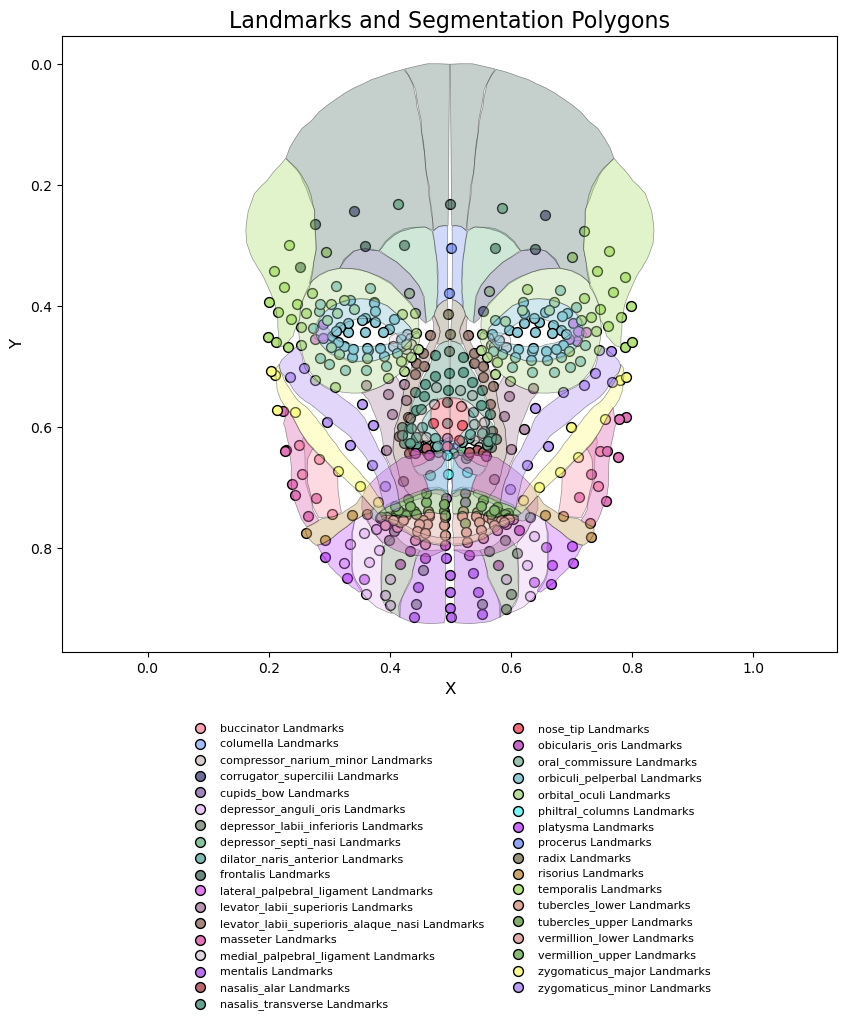

In [27]:
plot_landmarks_and_segments(mapped_landmarks_df)


In [28]:
def plot_landmarks_and_segments_with_polygon_annotations(df):
    fig, ax = plt.subplots(figsize=(12, 10))

    polygons = []
    colors = []

    for _, row in df.iterrows():
        # Generate random pastel colors for the polygons
        color = np.random.random(3) * 0.6 + 0.4

        # Add each segmentation polygon to the plot
        for polygon in row['segmentation']:
            polygon_array = np.array(polygon).reshape(-1, 2)  # Reshape to (N, 2)
            if polygon_array.shape[0] < 3:  # Skip malformed polygons (must have at least 3 points)
                continue
            polygons.append(Polygon(polygon_array, closed=True))
            colors.append(color)

            # Compute polygon centroid for annotation
            centroid = polygon_array.mean(axis=0)

            # Annotate the polygon with its name
            ax.annotate(
                row['name'],  # The name of the region
                (centroid[0], centroid[1]),
                textcoords="offset points",
                xytext=(20, -20),  # Offset to avoid overlap
                arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.8)
            )

        # Plot landmarks
        landmarks = np.array(row['landmark_coords'])
        ax.scatter(
            landmarks[:, 0],
            landmarks[:, 1],
            c=[color],
            edgecolors='k',
            s=50,
        )

    # Add polygons to the plot using PatchCollection
    p = PatchCollection(polygons, facecolor=colors, linewidths=0.5, edgecolor='k', alpha=0.4)
    ax.add_collection(p)

    # Configure plot
    ax.set_title("Annotated Polygons and Landmarks", fontsize=16)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.axis("equal")
    plt.gca().invert_yaxis()

    plt.show()


# CAMERA


In [29]:
import mediapipe as mp
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions

In [30]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
base_options = BaseOptions(model_asset_path='face_landmarker.task')
options = FaceLandmarkerOptions(base_options=base_options,
                                output_face_blendshapes=True,
                                output_facial_transformation_matrixes=True,
                                num_faces=1,
                                min_face_detection_confidence=.6,
                                min_tracking_confidence=.6)
detector = FaceLandmarker.create_from_options(options)

I0000 00:00:1732675738.556745   39915 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1732675738.559164   40023 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.2), renderer: AMD Radeon RX 580 Series (radeonsi, polaris10, LLVM 17.0.6, DRM 3.57, 6.8.0-47-generic)
W0000 00:00:1732675738.560062   39915 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1732675738.570005   40025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732675738.591441   40029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [31]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def project_polygons_on_face(dataframe, video_feed, detector, smoothing_alpha=0.5):
    """
    Projects polygon perimeters from the DataFrame onto the MediaPipe FaceMesh,
    with smoothed scaling and gradient pastel colors for each segmentation group.

    Args:
        dataframe (pd.DataFrame): DataFrame with columns:
            - 'segmentation': List of polygons [[x1, y1, x2, y2, ...], [...]] (normalized).
            - 'landmark': List of landmark labels that fall into the polygons.
            - 'coordinates': Corresponding normalized landmark coordinates [[x, y], ...].
        video_feed: Webcam video feed (OpenCV capture object).
        detector: MediaPipe face detection object.
        smoothing_alpha (float): Interpolation factor for smoothing scaling (0.0 to 1.0).
    """
    # Initialize storage for previous scaling factors
    prev_scale_x = prev_scale_y = 1.0

    # Generate unique pastel colors for each segmentation group
    num_groups = len(dataframe)
    colors = [(int(c[0] * 255), int(c[1] * 255), int(c[2] * 255))
                    for c in cm.rainbow(np.linspace(0, 1, num_groups))[:, :3]]

    while True:
        ret, frame = video_feed.read()
        if not ret:
            break
        
        height, width = frame.shape[:2]
        # Convert frame to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        detection_result = detector.detect(mp_image)
    
    
        if detection_result and detection_result.face_landmarks:
            print(detection_result.facial_transformation_matrixes)
            face_landmarks_list = detection_result.face_landmarks
            for idx in range(len(face_landmarks_list)):
                face_landmark = face_landmarks_list[idx]
                # Create a dictionary of MediaPipe landmarks
                mediapipe_landmarks = {
                        point: (landmark.x, landmark.y) for point, landmark in enumerate(face_landmark)}

                # Iterate through rows in the DataFrame
                for group_idx, (_, row) in enumerate(dataframe.iterrows()):
                    # Map DataFrame landmarks to MediaPipe landmarks
                
                    mapped_landmarks = []
                    for label in row['landmark']:
                        if label in mediapipe_landmarks:
                            mapped_landmarks.append(mediapipe_landmarks[label])
                    
                    if not mapped_landmarks or len(mapped_landmarks) < 2:
                        continue  # Skip if mapped landmarks are missing or invalid

                    # Calculate scaling factors based on landmark coordinates
                    df_landmarks = np.array(row['landmark_coords'])[:, :2]  # Use only x, y
                    mp_landmarks = np.array(mapped_landmarks)[:, :2]  # Use only x, y
                    
                    # Calculate centroids
                    centroid_df = df_landmarks.mean(axis=0)  # x, y centroid
                    centroid_mp = mp_landmarks.mean(axis=0)  # x, y centroid
                    range_x_df = df_landmarks[:, 0].max() - df_landmarks[:, 0].min()
                    range_y_df = df_landmarks[:, 1].max() - df_landmarks[:, 1].min()
                    range_x_mp = mp_landmarks[:, 0].max() - mp_landmarks[:, 0].min()
                    range_y_mp = mp_landmarks[:, 1].max() - mp_landmarks[:, 1].min()

                    # Avoid division by zero
                    scale_x = range_x_mp / range_x_df if range_x_df > 0 else 1.0
                    scale_y = range_y_mp / range_y_df if range_y_df > 0 else 1.0
       
                    # Scale and translate polygons relative to centroids
                    for polygon in row['segmentation']:
                        polygon_points = np.array(polygon).reshape(-1, 2)
                        # Translate polygon to origin relative to its centroid
                        translated_polygon = polygon_points - centroid_df
                        # Scale polygon
                        scaled_polygon = translated_polygon * [scale_x, scale_y]
                        # Translate polygon back to MediaPipe centroid
                        polygon_scaled = scaled_polygon + centroid_mp
                        # Convert to integer pixel coordinates
                        polygon_scaled_int = np.array(
                            [
                                [int(x * width), int(y * height)]
                                for x, y in polygon_scaled
                            ],
                            dtype=np.int32
                        )
            
                        # Draw polygon on the frame with unique color
                        cv2.polylines(frame, [polygon_scaled_int], isClosed=True, color=colors[group_idx], thickness=2)
                        overlay = frame.copy()
                        cv2.fillPoly(overlay, [polygon_scaled_int], color=colors[group_idx])
                        cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

        # Show the frame
        cv2.imshow("Polygon Projection", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    video_feed.release()
    cv2.destroyAllWindows()

In [32]:
import pandas as pd
from pathlib import Path

df = mapped_landmarks_df[['segmentation','landmark','landmark_coords']]
video_capture = cv2.VideoCapture(0)
project_polygons_on_face(df, video_capture,detector)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to target thread (0x5fa40b313930)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to target thread (0x5fa40b313930)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to target thread (0x5fa40b313930)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to target thread (0x5fa40b313930)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to target thread (0x5fa40b313930)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to target thread (0x5fa40b313930)

QObject::moveToThread: Current thread (0x5fa40b313930) is not the object's thread (0x5fa40be891d0).
Cannot move to tar

[array([[ 9.91077483e-01, -1.33017942e-01, -8.43009632e-03,
        -1.19790001e+01],
       [ 1.16654098e-01,  8.96272600e-01, -4.27886009e-01,
         7.81460953e+00],
       [ 6.44721612e-02,  4.23084855e-01,  9.03793037e-01,
        -4.26054077e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]
[array([[ 9.91618931e-01, -1.29149333e-01, -3.66144837e-03,
        -1.20217648e+01],
       [ 1.14071086e-01,  8.88451159e-01, -4.44571376e-01,
         7.89196730e+00],
       [ 6.06690273e-02,  4.40427452e-01,  8.95736635e-01,
        -4.25886726e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]
[array([[ 9.91454661e-01, -1.29915163e-01, -1.18036680e-02,
        -1.20640144e+01],
       [ 1.11684054e-01,  8.92101526e-01, -4.37813938e-01,
         7.91199350e+00],
       [ 6.74087331e-02,  4.32754368e-01,  8.98987830e-01,
        -4.27243118e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,